In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import magsim

# Field Models
The simulation models the fidelity of the velocity estimator using a fit to data from the 2023
MAGSPEED prototyping runs: the delay time error is fit to a quadratic of the inverse of the 
field gradient along the direction of motion. As such a magnetic anomaly field model is required
as input to the simulation. 

It is worthwhile to note that this simulation model is tied to the MAGSPEED prototype which
used magnetometers with a noise density of approximately 50 pT/sqrt(Hz) and the fit is only
valid for these sensors. At this point, it does not possess the capability to simulate
performance of sensors with lower (or higher) noise densities. 

## Tabulated Field Model
A tabulated field model is provided with global coverage based on the 
[WDMAM2.0 model](https://wdmam.org).
The field is stored in azimuthal equidistant projections for the northern and southern 
hemispheres. The bins are selected such that each pixel at the equator subtends 3 arc minutes.
The table is then 2x2290x2290. The northern hemisphere map is shown in the figure below. Note 
that the projection leaves unused elements in the four corners of the table (dark blue).

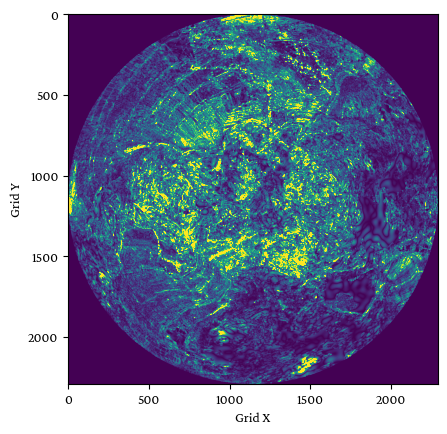

In [2]:
field_model = magsim.TabulatedFieldModel('data/field-3m.npy')
plt.imshow(np.fft.fftshift(np.abs(field_model.m[0])), vmin=0, vmax=200)
plt.grid(False)
plt.xlabel('Grid X')
plt.ylabel('Grid Y');

# MAGSim Simulation Class

## Construction and Use
A simulator is constructed by supplying a field model (in principle, any object that 
can compute a field gradient at given longitude and latitude), a sensor baseline, in 
units of length, and an optional random number generator class. If no RNG class is 
provided the simulation will construct one from `numpy.random.default_rng()`, however
in special cases it may be useful to supply one, such as to provide a repeatable 
sequence from a fixed seed.

In [9]:
rng = np.random.default_rng(101)
sim = magsim.MAGSim(field_model=field_model, baseline=20, rng=rng)

Simulation proceeds by calling the `estimator` method at Monte Carlo truth 
values of longitude and latitude, along with heading (usual clockwise from 
North convention) and speed. Units of speed and the baseline length can have
arbitary but equal length units but the time unit of the speed must be 
seconds. For example, if the baseline argument to the constructor above is
specified in feet, speed should be given in feet per second, if in meters, 
meters for second, and so on.

In [10]:
sim.estimator(lon=-75, lat=35, heading=225, speed=100)

94.679299375756

The estimator returns an estimate of the velocity with same units as the speed argument, 
subject to the aforementioned restriction on units.

## Simple Monte Carlo
For illustrative purposes, a simple Monte Carlo is given below. A simple stepper is
used here - production code should employ high-order methods (e.g. RK4).

In [25]:
dt = 0.025    # Stepping time in seconds, for linear steppers this must be small

# _t indicates MC truth information
lat_t, lon_t = (35, -75)
hdg, speed = (60, 100)

# Vessel starts out at known position 
lat, lon = lat_t, lon_t

NSTEP = 10000
for i in range(NSTEP):
    ve = sim.estimator(lon=lon_t, lat=lat_t, heading=hdg, speed=speed)
    dist_t = speed * dt * 0.001
    dist   = ve * dt * 0.001
    lat_t, lon_t = magsim.destination(tc=hdg, lat1=lat_t, long1=lon_t, d=dist_t)
    lat, lon = magsim.destination(tc=hdg, lat1=lat, long1=lon, d=dist)
    #print(i, ve, dist, dist_t, lat, lon, lat_t, lon_t)

print('After', NSTEP*dt, 'seconds latitude error is', lat-lat_t, 'longitude error is', lon-lon_t)

After 250.0 seconds latitude error is -0.00020221243898532748 longitude error is -0.0004286585399881915
